# Desafio Cientista de Dados
### Talyta Wenzel Feitoza da Silva Santos

## Instalando pacotes e importando bibliotecas:

In [1]:
!pip install -q seaborn
!pip install -q xlsxwriter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import string
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from collections import defaultdict, Counter


## Análise exploratória dos dados (EDA):

In [2]:
# Carregando o arquivo CSV da base de dados
base = pd.read_csv('desafio_indicium_imdb.csv')

# Exibindo as primeiras linhas da base de dados
print(base.head())


   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  W

In [3]:
# Verificar os tipos de cada coluna
print(base.dtypes)

Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object


In [4]:
# Removendo o texto "min" da coluna Runtime e convertendo-a para o tipo inteiro
base['Runtime'] = base['Runtime'].str.replace(' min', '').astype(int)

# Removendo as vírgulas da coluna Gross e convertendo-a para float
base['Gross'] = base['Gross'].str.replace(',', '').astype(float)

# Substituindo os valores nulos por NaN na coluna Released_Year e convertendo- para float
base['Released_Year'] = pd.to_numeric(base['Released_Year'], errors='coerce')

# Substituindo os valores nulos por NaN na coluna Released_Year
base.loc[base['Released_Year'] == 0, 'Released_Year'] = pd.NA

# Renomeando a coluna Runtime para Runtime (min)
base = base.rename(columns={'Runtime': 'Runtime (min)'})

# Exibindo as primeiras linhas da base de dados após ajustes
print(base.head())

   Unnamed: 0                                   Series_Title  Released_Year  \
0           1                                  The Godfather         1972.0   
1           2                                The Dark Knight         2008.0   
2           3                         The Godfather: Part II         1974.0   
3           4                                   12 Angry Men         1957.0   
4           5  The Lord of the Rings: The Return of the King         2003.0   

  Certificate  Runtime (min)                     Genre  IMDB_Rating  \
0           A            175              Crime, Drama          9.2   
1          UA            152      Action, Crime, Drama          9.0   
2           A            202              Crime, Drama          9.0   
3           U             96              Crime, Drama          9.0   
4           U            201  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty'

In [5]:
# Verificando os tipos de cada coluna
print(base.dtypes)

Unnamed: 0         int64
Series_Title      object
Released_Year    float64
Certificate       object
Runtime (min)      int32
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object


In [6]:
# Calculando as estatísticas descritivas 
desc_stats= base.describe(include='all')

# Adicionando moda 
for col in base.select_dtypes(include='object').columns:
    desc_stats.loc['mean', col] = base[col].mode().iloc[0]  # moda

# Calculando a mediana 
for col in base.select_dtypes(include='number').columns:
    desc_stats.loc['median', col] = base[col].median()     # mediana

# Adicionando contagem
desc_stats.loc['count'] = base.count()

# Mostrando os resultados
print(desc_stats)

        Unnamed: 0 Series_Title  Released_Year Certificate  Runtime (min)  \
count   999.000000          999     998.000000         898     999.000000   
unique         NaN          998            NaN          16            NaN   
top            NaN     Drishyam            NaN           U            NaN   
freq           NaN            2            NaN         234            NaN   
mean    500.000000     Drishyam    1991.214429           U     122.871872   
std     288.530761          NaN      23.308539         NaN      28.101227   
min       1.000000          NaN    1920.000000         NaN      45.000000   
25%     250.500000          NaN    1976.000000         NaN     103.000000   
50%     500.000000          NaN    1999.000000         NaN     119.000000   
75%     749.500000          NaN    2009.000000         NaN     137.000000   
max     999.000000          NaN    2020.000000         NaN     321.000000   
median  500.000000          NaN    1999.000000         NaN     119.000000   

In [7]:
# Para melhor avaliar as estatísticas para os atores, compilou-se as quatro colunas:
# Criando uma lista com os nomes das colunas de estrelas
columns_to_analyze = ['Star1', 'Star2', 'Star3', 'Star4']

# Inicializando um DataFrame para armazenar as estatísticas descritivas
desc_stats = pd.DataFrame(index=['count', 'unique', 'top', 'freq', 'mean'])

# Calculando as estatísticas descritivas para a coluna compilada de atores
compiled_column = base[columns_to_analyze].values.ravel()

# Calculando a contagem
desc_stats.loc['count', 'Actors'] = len(compiled_column)

# Calculando valores únicos
unique_values, unique_counts = pd.Series(compiled_column).value_counts().index, pd.Series(compiled_column).value_counts().values
desc_stats.loc['unique', 'Actors'] = len(unique_values)

# Calculando o ator principal
top_value = pd.Series(compiled_column).mode().iloc[0]
desc_stats.loc['top', 'Actors'] = top_value

# Calculando a frequência
top_freq = pd.Series(compiled_column).value_counts().max()
desc_stats.loc['freq', 'Actors'] = top_freq

# Calculando a média 
mean_freq = pd.Series(compiled_column).value_counts().mean()
desc_stats.loc['mean', 'Actors'] = mean_freq

# Mostrando os resultados
print(desc_stats)

                Actors
count           3996.0
unique          2707.0
top     Robert De Niro
freq                17
mean          1.476173


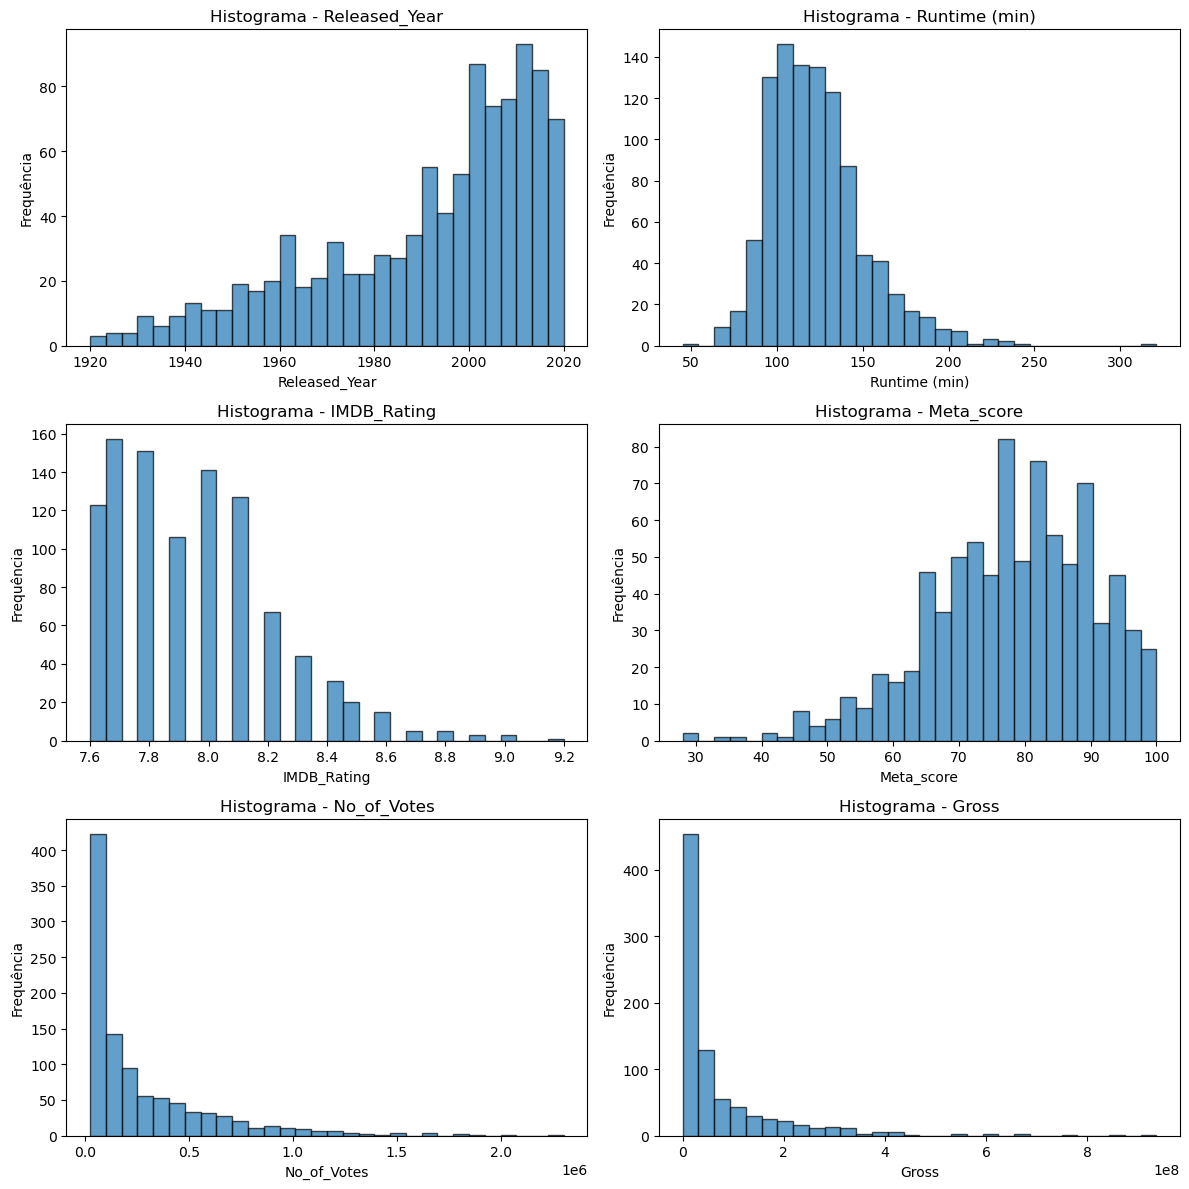

In [8]:
# Lista das colunas numéricas de interesse
numeric_columns = ['Released_Year', 'Runtime (min)', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']

# Configurações para layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Iterações sobre cada coluna e plotagem dos histograma
for i, col in enumerate(numeric_columns):
    ax = axes.flatten()[i]
    ax.hist(base[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'Histograma - {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

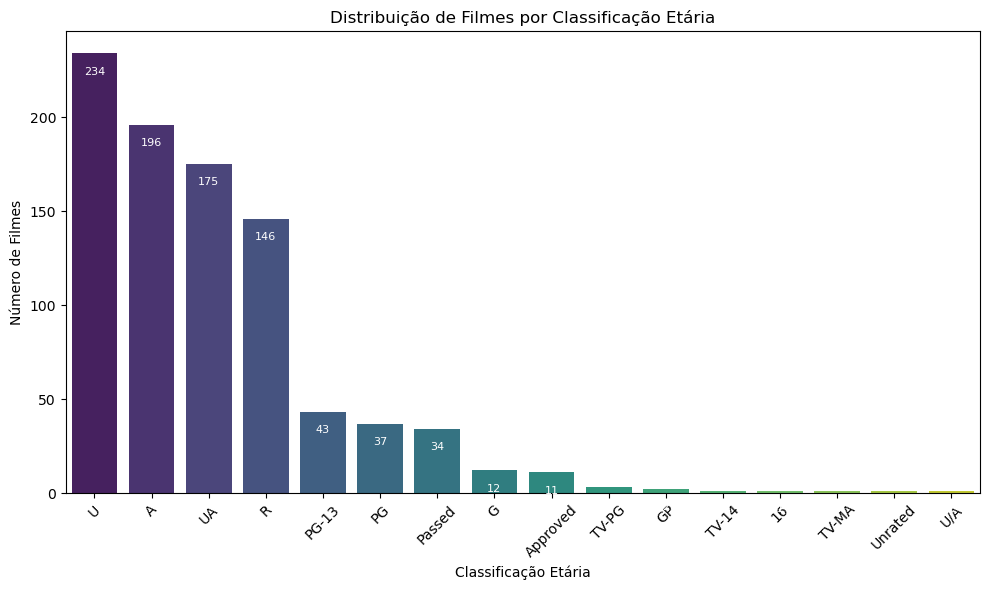

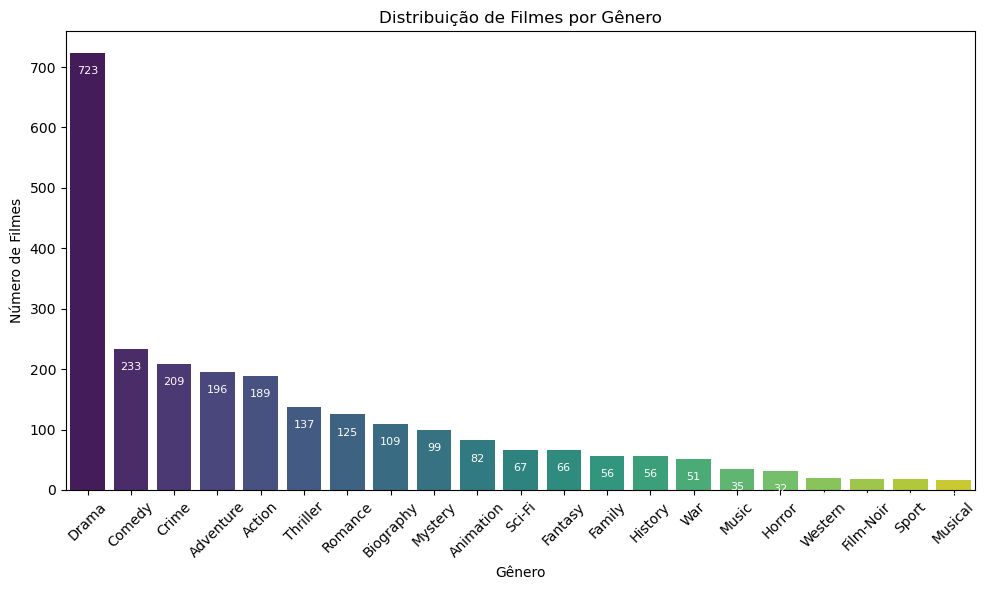

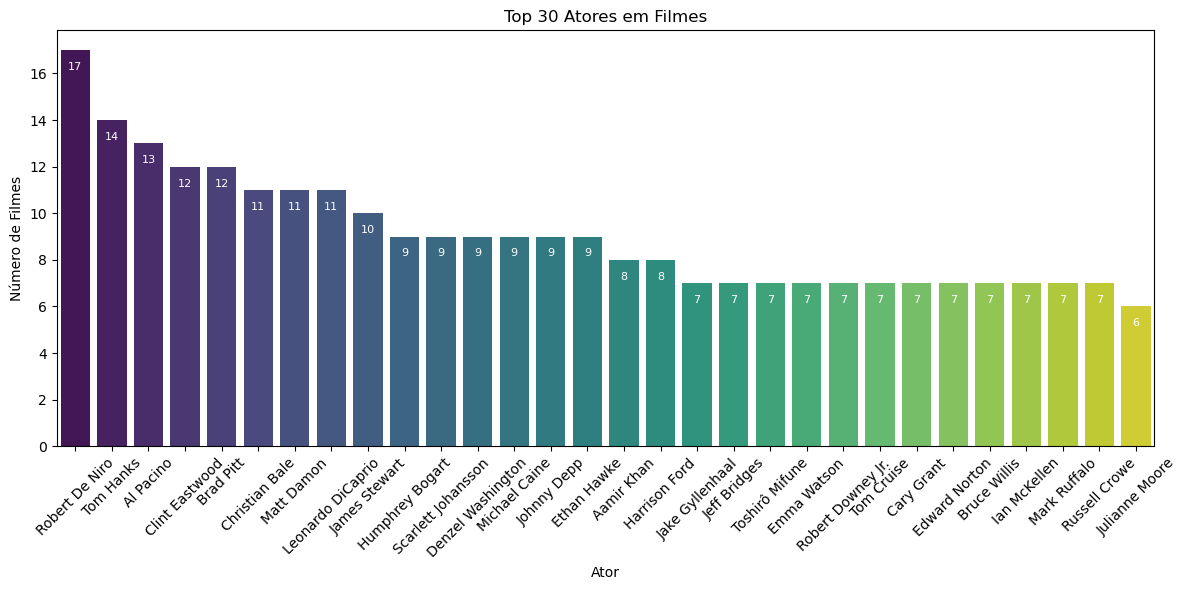

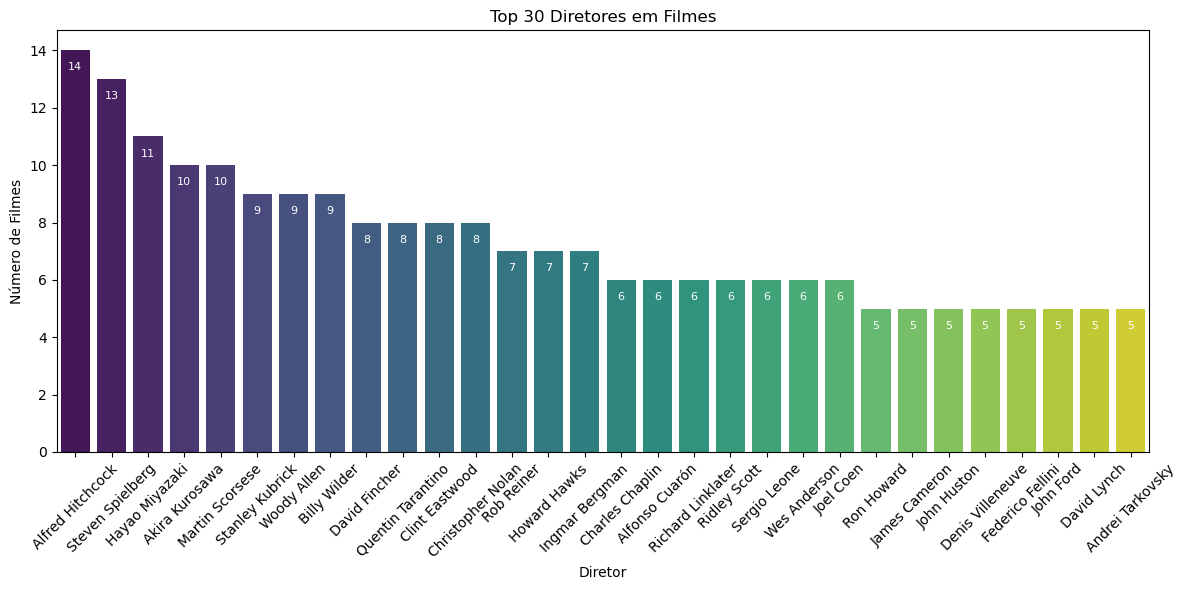

In [22]:
df = pd.DataFrame(base)

# -------------------------
# Distribuição por Certificado
# -------------------------
df_separated_cert = df.assign(Certificate=df['Certificate'].str.split(', ')).explode('Certificate')
certificate_counts = df_separated_cert['Certificate'].value_counts()

plt.figure(figsize=(10, 6))
plot_certificates = sns.barplot(x=certificate_counts.index, y=certificate_counts.values, palette='viridis')
plt.title('Distribuição de Filmes por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando legendas
for bar, count in zip(plot_certificates.patches, certificate_counts.values):
    plot_certificates.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03 * max(certificate_counts.values), count, ha='center', va='top', fontsize=8, color='white')

plt.show()

# -------------------------
# Distribuição por Gênero
# -------------------------
df_separated_genre = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
genre_counts = df_separated_genre['Genre'].value_counts()

plt.figure(figsize=(10, 6))
plot_genres = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Distribuição de Filmes por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando legendas
for bar, count in zip(plot_genres.patches, genre_counts.values):
    plot_genres.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03 * max(genre_counts.values), count, ha='center', va='top', fontsize=8, color='white')

plt.show()

# -------------------------
# Distribuição de Atores
# -------------------------
df_actors = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']]).value_counts()
df_actors_top30 = df_actors.head(30)

plt.figure(figsize=(12, 6))
plot_actors = sns.barplot(x=df_actors_top30.index, y=df_actors_top30.values, palette='viridis')
plt.title('Top 30 Atores em Filmes')
plt.xlabel('Ator')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando legendas
for bar, count in zip(plot_actors.patches, df_actors_top30.values):
    plot_actors.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03 * max(df_actors_top30.values), count, ha='center', va='top', fontsize=8, color='white')

plt.show()

# -------------------------
# Distribuição de Diretores
# -------------------------
df_directors = df['Director'].value_counts()
df_directors_top30 = df_directors.head(30)

plt.figure(figsize=(12, 6))
plot_directors = sns.barplot(x=df_directors_top30.index, y=df_directors_top30.values, palette='viridis')
plt.title('Top 30 Diretores em Filmes')
plt.xlabel('Diretor')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionando legendas
for bar, count in zip(plot_directors.patches, df_directors_top30.values):
    plot_directors.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03 * max(df_directors_top30.values), count, ha='center', va='top', fontsize=8, color='white')

plt.show()

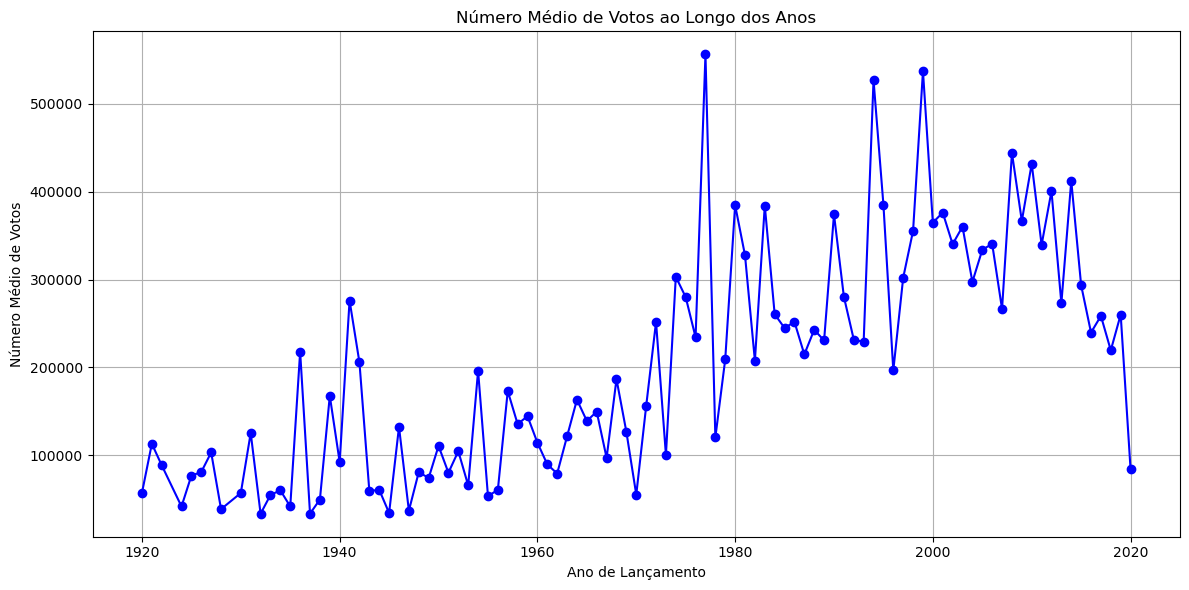

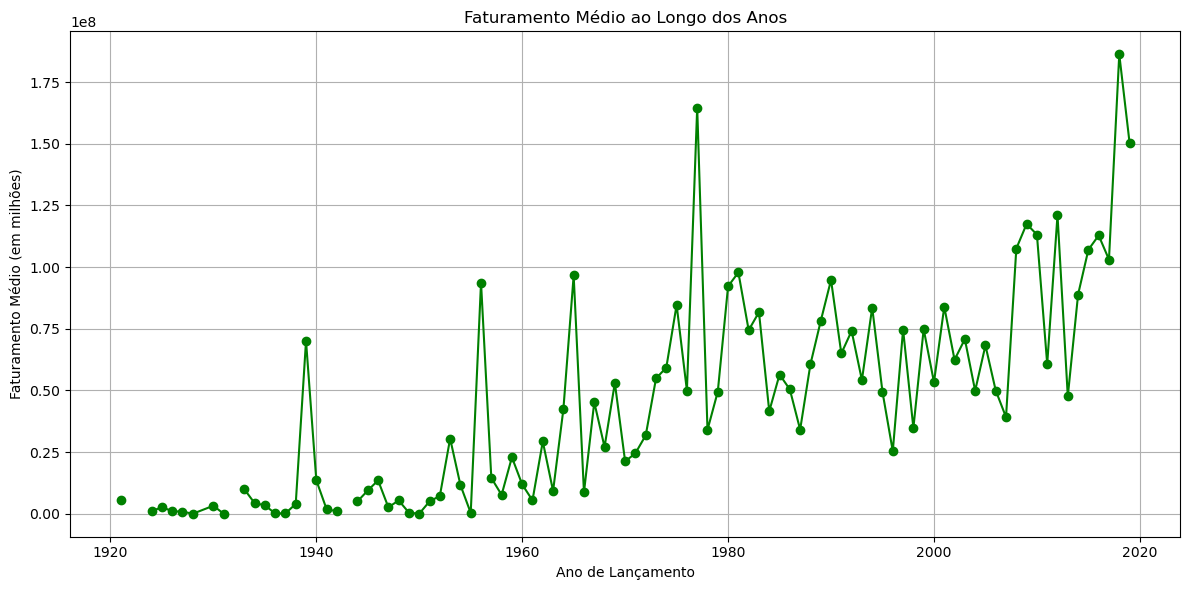

In [10]:
# Convertendo a coluna Released_Year para datetime
df['Released_Year'] = pd.to_datetime(df['Released_Year'], format='%Y', errors='coerce')

# Agrupando por ano e calculando a média de votos e faturamento por ano
votes_by_year = df.groupby(df['Released_Year'].dt.year)['No_of_Votes'].mean()
gross_by_year = df.groupby(df['Released_Year'].dt.year)['Gross'].mean()

# Plotando o gráfico de linha de votos ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(votes_by_year.index, votes_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Número Médio de Votos ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Número Médio de Votos')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotando o gráfico de linha de faturamento ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(gross_by_year.index, gross_by_year.values, marker='o', linestyle='-', color='g')
plt.title('Faturamento Médio ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Faturamento Médio (em milhões)')
plt.grid(True)
plt.tight_layout()
plt.show()

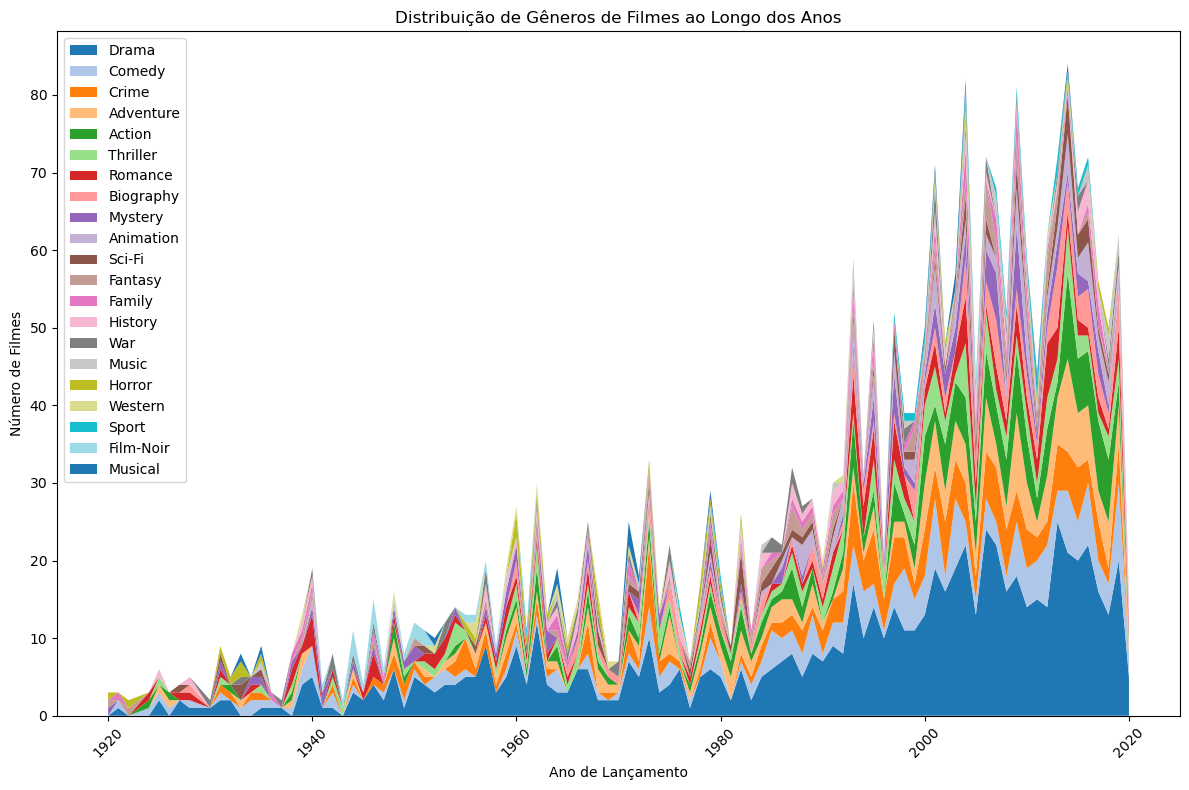

In [11]:
# Convertendo a coluna Released_Year para datetime
df['Released_Year'] = pd.to_datetime(df['Released_Year'], format='%Y-%m-%d', errors='coerce')

# Separando os filmes que possuem múltiplos gêneros
df_separated_genre = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Contando o número de filmes por gênero e ano
genre_counts_by_year = df_separated_genre.groupby(['Released_Year', 'Genre']).size().reset_index(name='Count')

# Pivotando os dados para ter gêneros como colunas
pivot_genre_counts = genre_counts_by_year.pivot(index='Released_Year', columns='Genre', values='Count').fillna(0)

# Ordenando as colunas pelo total de filmes ao longo dos anos
pivot_genre_counts = pivot_genre_counts.reindex(pivot_genre_counts.sum().sort_values(ascending=False).index, axis=1)

# Criando o gráfico 
plt.figure(figsize=(12, 8))
plt.stackplot(pivot_genre_counts.index, pivot_genre_counts.values.T, labels=pivot_genre_counts.columns, colors=plt.cm.tab20.colors)
plt.title('Distribuição de Gêneros de Filmes ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Número de Filmes')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

            IMDB_Rating                Gross              
                   mean median          mean        median
Certificate                                               
16             8.100000   8.10  6.808257e+07  6.808257e+07
A              7.992347   8.00  6.443238e+07  5.171968e+07
Approved       7.945455   8.00  3.473700e+07  2.365000e+07
G              8.000000   8.00  5.267737e+07  4.181362e+07
GP             7.850000   7.85  7.089580e+05  7.089580e+05
PG             7.927027   7.90  3.552411e+07  3.017751e+07
PG-13          7.797674   7.70  3.984411e+07  1.825470e+07
Passed         8.020588   8.05  2.570371e+07  8.000000e+06
R              7.869863   7.80  2.897976e+07  7.488686e+06
TV-14          8.300000   8.30  6.808257e+07  6.808257e+07
TV-MA          8.100000   8.10  6.808257e+07  6.808257e+07
TV-PG          7.900000   8.00  4.542394e+07  6.808257e+07
U              7.976923   8.00  8.446207e+07  5.558118e+07
U/A            7.600000   7.60  2.602096e+07  2.602096e+

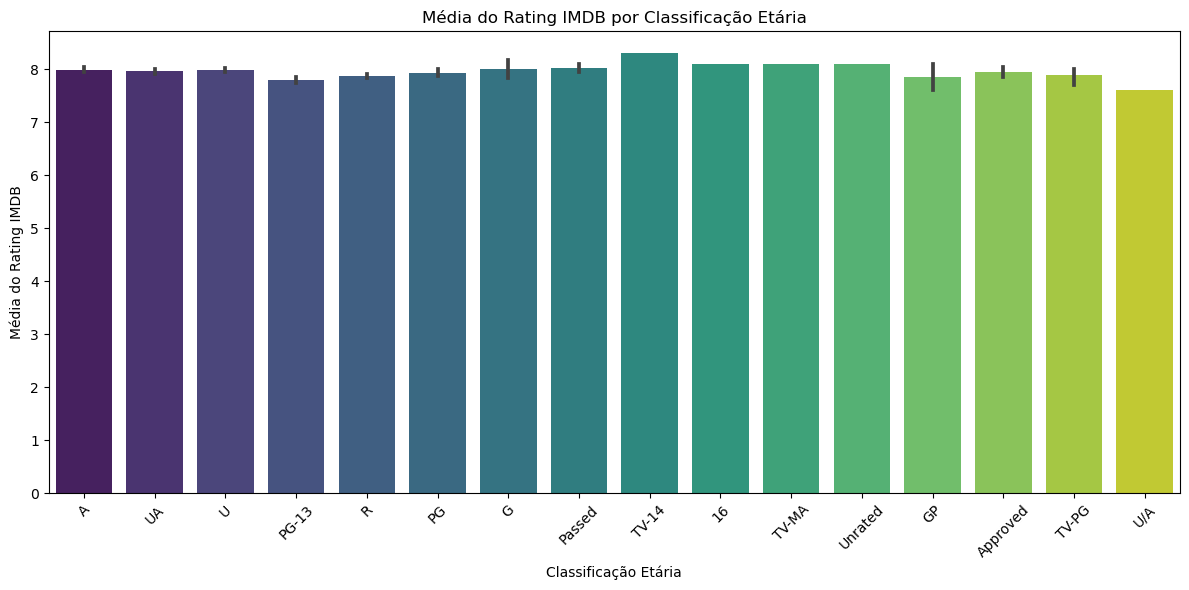

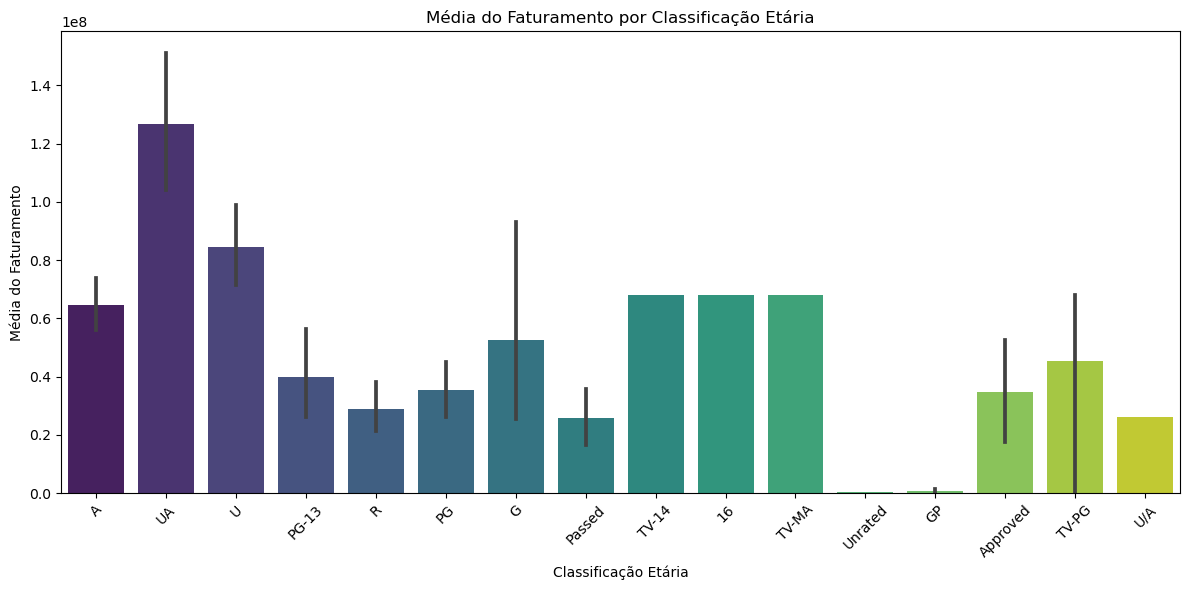

In [12]:
# Verificando e tratando os valores não existentes em 'IMDB_Rating' e 'Gross'
base['IMDB_Rating'].fillna(base['IMDB_Rating'].mean(), inplace=True)
base['Gross'].fillna(base['Gross'].mean(), inplace=True)

# Calculando estatísticas resumidas por classificação etária
summary_stats = base.groupby('Certificate').agg({'IMDB_Rating': ['mean', 'median'], 'Gross': ['mean', 'median']})
print(summary_stats)

# Plotando gráficos de barras para média do rating IMDB por classificação etária
plt.figure(figsize=(12, 6))
sns.barplot(x='Certificate', y='IMDB_Rating', data=base, estimator=np.mean, palette='viridis')
plt.title('Média do Rating IMDB por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Média do Rating IMDB')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotando gráficos de barras para média do faturamento por classificação etária
plt.figure(figsize=(12, 6))
sns.barplot(x='Certificate', y='Gross', data=base, estimator=np.mean, palette='viridis')
plt.title('Média do Faturamento por Classificação Etária')
plt.xlabel('Classificação Etária')
plt.ylabel('Média do Faturamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Recomendações de filme para pessoas desconhecidas:

In [24]:

# Criando classificações por faixa etárias
def classificacao_para_faixa_etaria(classificacao):
    if classificacao in ['U', 'G', 'Approved', 'UA', 'U/A']:
        return 'Geral (Apto para todas as idades)'
    elif classificacao in ['PG', 'TV-G']:
        return 'Geral (Apto para todas as idades)'
    elif classificacao in ['PG-13', '16', 'TV-14']:
        return 'Parental Guidance Suggested (PG)'
    elif classificacao in ['R', 'TV-MA']:
        return 'Restrito (R)'
    elif classificacao == 'Unrated':
        return 'Não classificado oficialmente'
    else:
        return 'Outro'

# Encontrando o melhor filme por gênero para cada faixa etária
def melhores_filmes_por_faixa_etaria_e_genero(df):
    # Separando os filmes que possuem múltiplos gêneros
    df_separated_genre = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
    
    # Mapeando as classificações para faixas etárias
    df_separated_genre['Faixa_Etaria'] = df_separated_genre['Certificate'].apply(classificacao_para_faixa_etaria)
    
    # Filtrando por faixas etárias específicas
    df_geral = df_separated_genre[df_separated_genre['Faixa_Etaria'] == 'Geral (Apto para todas as idades)']
    df_pg = df_separated_genre[df_separated_genre['Faixa_Etaria'] == 'Parental Guidance Suggested (PG)']
    df_restrito = df_separated_genre[df_separated_genre['Faixa_Etaria'] == 'Restrito (R)']
    df_nao_classificado = df_separated_genre[df_separated_genre['Faixa_Etaria'] == 'Não classificado oficialmente']
    
    # Criando listas para armazenar os melhores filmes por gênero
    melhores_geral = []
    melhores_pg = []
    melhores_restrito = []
    melhores_nao_classificado = []
    
    # Encontrando os melhores filmes por gênero em cada faixa etária
    for faixa, df_faixa in [('Geral (Apto para todas as idades)', df_geral), 
                            ('Parental Guidance Suggested (PG)', df_pg), 
                            ('Restrito (R)', df_restrito), 
                            ('Não classificado oficialmente', df_nao_classificado)]:
        for genre, df_genre in df_faixa.groupby('Genre'):
            melhor_filme = df_genre.loc[df_genre['IMDB_Rating'].idxmax()]
            if faixa == 'Geral (Apto para todas as idades)':
                melhores_geral.append((genre, melhor_filme['Series_Title']))
            elif faixa == 'Parental Guidance Suggested (PG)':
                melhores_pg.append((genre, melhor_filme['Series_Title']))
            elif faixa == 'Restrito (R)':
                melhores_restrito.append((genre, melhor_filme['Series_Title']))
            elif faixa == 'Não classificado oficialmente':
                melhores_nao_classificado.append((genre, melhor_filme['Series_Title']))
    
    # Criando DataFrames com os melhores filmes por gênero e faixa etária
    df_melhores_geral = pd.DataFrame(melhores_geral, columns=['Genre', 'Melhor_Filme'])
    df_melhores_pg = pd.DataFrame(melhores_pg, columns=['Genre', 'Melhor_Filme'])
    df_melhores_restrito = pd.DataFrame(melhores_restrito, columns=['Genre', 'Melhor_Filme'])
    df_melhores_nao_classificado = pd.DataFrame(melhores_nao_classificado, columns=['Genre', 'Melhor_Filme'])
    
    return df_melhores_geral, df_melhores_pg, df_melhores_restrito, df_melhores_nao_classificado

# Chamando a função para obter as tabelas de melhores filmes por gênero e faixa etária
df_geral, df_pg, df_restrito, df_nao_classificado = melhores_filmes_por_faixa_etaria_e_genero(df)

# Mostrando as tabelas
print("Melhores Filmes por Gênero (Geral - Apto para todas as idades):")
print(df_geral)
print("\nMelhores Filmes por Gênero (Orientação dos pais):")
print(df_pg)
print("\nMelhores Filmes por Gênero (Restrito - R):")
print(df_restrito)
print("\nMelhores Filmes por Gênero (Não classificado oficialmente):")
print(df_nao_classificado)

Melhores Filmes por Gênero (Geral - Apto para todas as idades):
        Genre                                    Melhor_Filme
0      Action                                 The Dark Knight
1   Adventure   The Lord of the Rings: The Return of the King
2   Animation                   Sen to Chihiro no kamikakushi
3   Biography                                The Intouchables
4      Comedy                                 La vita è bella
5       Crime                                 The Dark Knight
6       Drama                                 The Dark Knight
7      Family                   Sen to Chihiro no kamikakushi
8     Fantasy  Star Wars: Episode V - The Empire Strikes Back
9   Film-Noir                                 Ace in the Hole
10    History                                     The Message
11     Horror                               Shaun of the Dead
12      Music                                       Andhadhun
13    Musical                                           Anand
14    

## Fatores relacionados com a alta expectativa de faturamento de um filme:

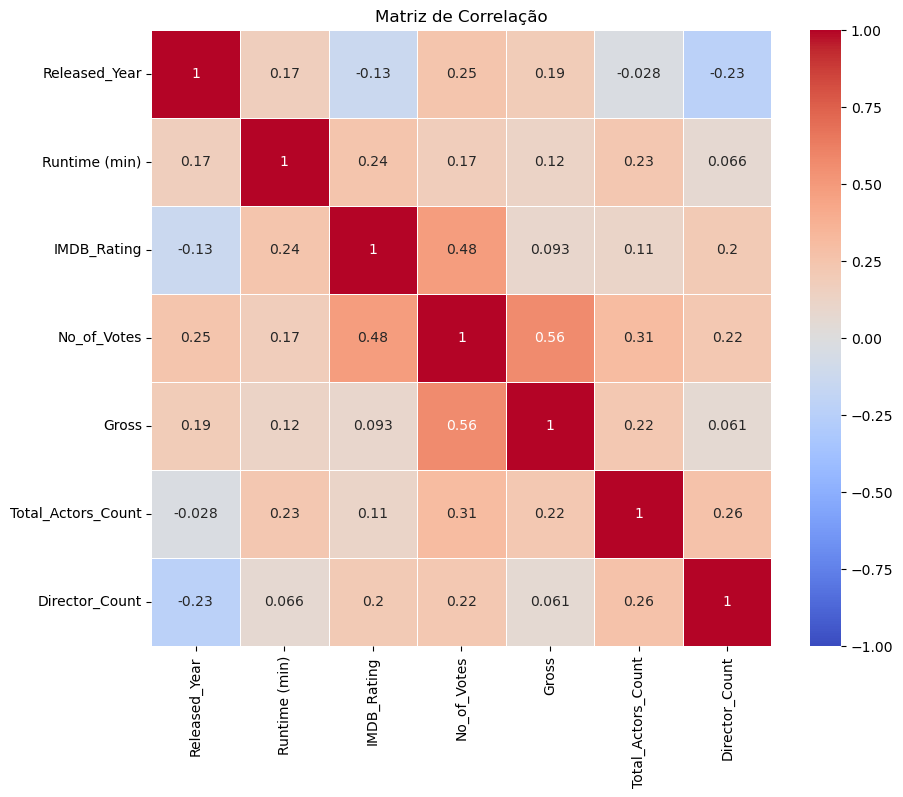

Correlação do Faturamento (Gross) com outras variáveis:
Released_Year         0.192868
Runtime (min)         0.124919
IMDB_Rating           0.092968
No_of_Votes           0.563484
Gross                 1.000000
Total_Actors_Count    0.220978
Director_Count        0.060969
Name: Gross, dtype: float64


In [15]:
df = pd.DataFrame(base)

# Removendo a coluna Certificate
df.drop(columns=['Certificate'], inplace=True)

# Criando função para calcular as ocorrências de atores e diretor
def count_actors_and_director(df):
    actors_columns = ['Star1', 'Star2', 'Star3']
    for col in actors_columns:
        df[f'{col}_Count'] = df[col].map(df[col].value_counts())
    df['Director_Count'] = df['Director'].map(df['Director'].value_counts())

    # Somar as contagens de todos os atores em uma única coluna
    df['Total_Actors_Count'] = df[[f'{col}_Count' for col in actors_columns]].sum(axis=1)
    
    return df

# Chamando a função para calcular os atores e diretor
df = count_actors_and_director(df)

# Selecionando colunas numéricas para calcular a correlação
numeric_columns = ['Released_Year', 'Runtime (min)', 'IMDB_Rating', 'No_of_Votes', 'Gross', 'Total_Actors_Count', 'Director_Count']

# Calculando a matriz de correlação
correlation_matrix = df[numeric_columns].corr()

# Plotando o heatmap da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()


# Imprimindo a correlação do faturamento com as outras variáveis
print("Correlação do Faturamento (Gross) com outras variáveis:")
print(correlation_matrix['Gross'])

## Insights da coluna Overview:

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\talyt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\talyt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


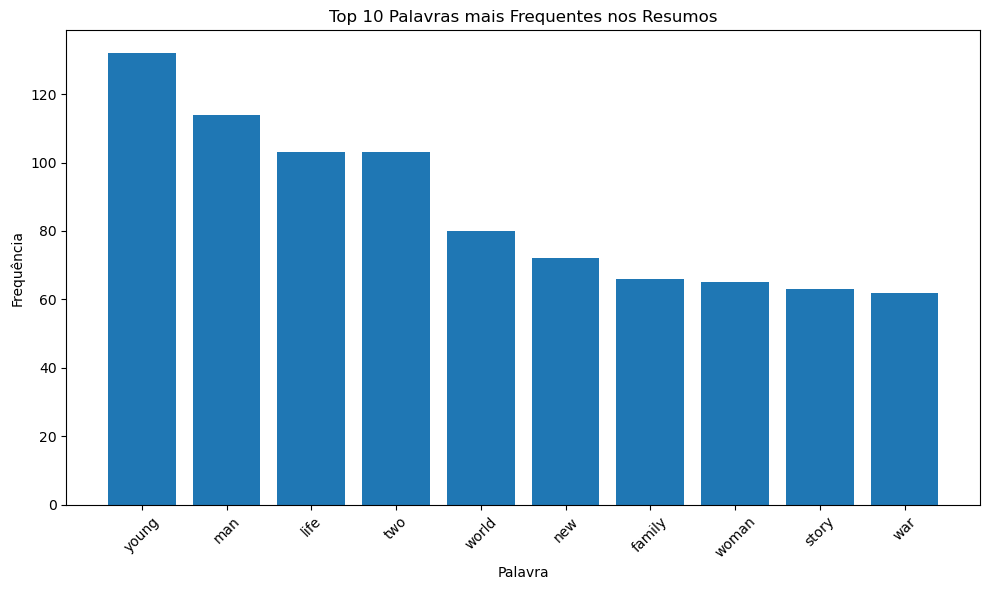

In [16]:
df = pd.DataFrame(base)

# Baixando a lista de stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Criando função para o pré-processamento de texto
def preprocess_text(text):
    # Tokenização
    tokens = word_tokenize(text.lower())  # Converte para minúsculas e tokeniza

    # Remoção de stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    return filtered_tokens

# Pré-processamento dos resumos
df['Preprocessed_Overview'] = df['Overview'].apply(preprocess_text)

# Contagem de palavras
all_words = []
for tokens in df['Preprocessed_Overview']:
    all_words.extend(tokens)

word_freq = Counter(all_words)

# Plotando as palavras mais frequentes
most_common = word_freq.most_common(10)  # Top 10 palavras mais comuns

plt.figure(figsize=(10, 6))
plt.bar([word[0] for word in most_common], [word[1] for word in most_common])
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Top 10 Palavras mais Frequentes nos Resumos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df = pd.DataFrame(base)

# Mapeamento dos gêneros para palavras-chave associadas
genre_keywords = {
    'Romance': ['romantic', 'love', 'relationship'],
    'Comedy': ['comedy', 'funny', 'humor'],
    'Crime': ['crime', 'criminal', 'detective'],
    'Drama': ['drama', 'emotional', 'life'],
    'Fantasy': ['fantasy', 'magic', 'enchanted'],
    'Adventure': ['adventure', 'journey', 'quest']
}

# Função para inferir os gêneros dos filmes
def infer_genre(overview):
    overview = overview.lower()
    genre_scores = defaultdict(int)

    # Contagem de palavras-chave para cada gênero
    for genre, keywords in genre_keywords.items():
        for keyword in keywords:
            if keyword in overview:
                genre_scores[genre] += 1

    # Retornando o gênero com maior contagem de palavras-chave
    if genre_scores:
        inferred_genre = max(genre_scores, key=genre_scores.get)
    else:
        inferred_genre = None

    return inferred_genre

# Aplicando a função para inferir gêneros aos dados
df['Inferred_Genre'] = df['Overview'].apply(infer_genre)

# Função para verificar se o gênero inferido está correto
def verifica_genero_inferido(row):
    real_genres = set(row['Genre'].split(', '))
    inferred_genre = row['Inferred_Genre']
    if inferred_genre in real_genres:
        return 'Correto'
    else:
        return 'Incorreto'

# Aplicando a função para verificar o gênero inferido
df['Verificacao_Genero_Inferido'] = df.apply(verifica_genero_inferido, axis=1)

# Mostrando os resultados
print(df[['Series_Title', 'Overview', 'Genre', 'Inferred_Genre', 'Verificacao_Genero_Inferido']])

                                      Series_Title  \
0                                    The Godfather   
1                                  The Dark Knight   
2                           The Godfather: Part II   
3                                     12 Angry Men   
4    The Lord of the Rings: The Return of the King   
..                                             ...   
994                         Breakfast at Tiffany's   
995                                          Giant   
996                          From Here to Eternity   
997                                       Lifeboat   
998                                   The 39 Steps   

                                              Overview  \
0    An organized crime dynasty's aging patriarch t...   
1    When the menace known as the Joker wreaks havo...   
2    The early life and career of Vito Corleone in ...   
3    A jury holdout attempts to prevent a miscarria...   
4    Gandalf and Aragorn lead the World of Men agai...   
.. 

## Previsão da nota do IMDb:

In [18]:
# Definindo os dados do novo filme
novo_filme = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28341469'}


# Combinando com o DataFrame original
df = pd.DataFrame(base)
df_new = pd.DataFrame([novo_filme])
df_combined = pd.concat([df, df_new], ignore_index=True)

# Processando a coluna 'Gross' para remover vírgulas e converter para o tipo numérico
df_combined['Gross'] = pd.to_numeric(df_combined['Gross'].astype(str).str.replace(',', ''), errors='coerce')

# Verificando e tratando os valores ausentes em y (IMDB_Rating)
if df_combined['IMDB_Rating'].isnull().any():
    df_combined.dropna(subset=['IMDB_Rating'], inplace=True)  

# Separando as variáveis X e y
X = df_combined[['Released_Year', 'No_of_Votes', 'Gross']]
y = df_combined['IMDB_Rating']

# Imputando os valores ausentes usando SimpleImputer com média apenas para o novo filme
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Separando o novo filme para previsão
X_new = X_imputed[-1].reshape(1, -1)  

# Criando um modelo de regressão linear
model = LinearRegression()

# Treinando o modelo com os dados imputados
model.fit(X_imputed, y)

# Fazendo a previsão para o novo filme
imdb_rating_pred = model.predict(X_new)

# Exibindo a previsão da nota do IMDb para o novo filme
print(f"A previsão da nota do IMDb para o filme '{novo_filme['Series_Title']}' é: {imdb_rating_pred[0]:.2f}")

A previsão da nota do IMDb para o filme 'The Shawshank Redemption' é: 7.99


## Pacotes instalados:

In [19]:
import pkg_resources

# Listar todos os pacotes instalados
installed_packages = pkg_resources.working_set

# Imprimir nome do pacote e versão
for package in installed_packages:
    print(f"{package.key}=={package.version}")

automat==20.2.0
babel==2.11.0
bottleneck==1.3.5
flask==2.2.2
heapdict==1.0.1
jinja2==3.1.2
markdown==3.4.1
markupsafe==2.1.1
pillow==9.4.0
protego==0.1.16
pydispatcher==2.0.5
pyjwt==2.4.0
pynacl==1.5.0
pyqt5==5.15.7
pyqt5-sip==12.11.0
pyqtwebengine==5.15.4
pysocks==1.7.1
pywavelets==1.4.1
pyyaml==6.0
pygments==2.15.1
qdarkstyle==3.0.2
qtawesome==1.2.2
qtpy==2.2.0
rtree==1.0.1
sqlalchemy==1.4.39
scrapy==2.8.0
send2trash==1.8.0
sphinx==5.0.2
tbb==0.2
twisted==22.10.0
unidecode==1.2.0
werkzeug==2.2.3
xlsxwriter==3.2.0
aiobotocore==2.5.0
aiofiles==22.1.0
aiohttp==3.8.5
aioitertools==0.7.1
aiosignal==1.2.0
aiosqlite==0.18.0
alabaster==0.7.12
anaconda-anon-usage==0.4.2
anaconda-catalogs==0.2.0
anaconda-client==1.12.1
anaconda-cloud-auth==0.1.3
anaconda-navigator==2.5.0
anaconda-project==0.11.1
anyio==3.5.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
astroid==2.14.2
astropy==5.1
asttokens==2.0.5
async-timeout==4.0.2
atomicwrites==1.4.0
attrs==22.1.0
autopep8==